<a href="https://colab.research.google.com/github/cesong2/Display-Sensor/blob/yngkyng/%EB%8D%B0%EC%9D%B4%ED%84%B01_%EC%8B%AC%ED%99%94%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import timedelta
import datetime
import numpy as np
from datetime import datetime
import time

In [10]:
#Load the data
telemetry_df = pd.read_csv("/content/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/PdM_errors.csv")
maint_df = pd.read_csv("/content/PdM_maint.csv")
failures_df = pd.read_csv("/content/PdM_failures.csv")
machines_df = pd.read_csv("/content/PdM_machines.csv")

##1. 사용연식, 에러횟수, 교체횟수, 고장횟수 간 상관관계 찾기
* 사용연식 - machineID의 age (machines.csv)
* 에러횟수 - groupby machineID, count * (errors.csv)
* 교체횟수 - groupby machineID, count * (maint.csv)
* 고장횟수 - groupby machineID, count * (failure.csv)

In [3]:
# 필요한 데이터 추출
machines_age = pd.DataFrame(machines_df[['machineID','age']]).set_index('machineID')
machines_errors = pd.DataFrame(errors_df.groupby('machineID')['errorID'].count())
machines_maint = pd.DataFrame(maint_df.groupby('machineID')['comp'].count())
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [4]:
# 추출한 데이터 합치기
df_machines = pd.concat([machines_age, machines_errors, machines_maint, machines_failures], axis=1)
df_machines.rename(columns={'errorID':'error', 'comp':'replace'},inplace=True)
df_machines

,age,error,replace,failure
machineID,,,,
1,18,35,37,7.0
2,7,28,32,4.0
3,8,39,37,5.0
4,7,31,33,6.0
5,2,38,35,7.0
...,...,...,...,...
96,10,39,33,5.0
97,14,45,34,8.0
98,20,45,37,16.0


In [5]:
# 상관관계 찾기 (피어슨 상관계수 사용)
df_machines.corr(method = "pearson")

,age,error,replace,failure
age,1.000000,0.106931,0.075445,0.476459
error,0.106931,1.000000,-0.026558,0.483735
replace,0.075445,-0.026558,1.000000,-0.030258
failure,0.476459,0.483735,-0.030258,1.000000


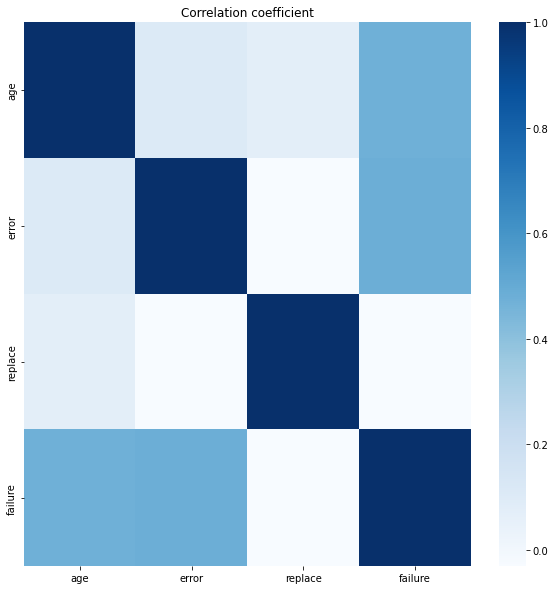

In [45]:
# 히트맵 시각화
matplotlib.rcParams['font.family'] = "NaNumGothic"  #나눔고딕체 사용
colormap = plt.cm.Blues  #색설정 : Blues
plt.figure(figsize = (10,10))
plt.title("Correlation coefficient")
sns.heatmap(df_machines.astype(float).corr(), cmap=colormap)
#이미지 저장
plt.savefig('heatmap1.png', transparent=True)

In [ ]:
### 결론 : 사용연식과 고장횟수 사이 / 에러횟수와 고장횟수 사이는 각각 약한 상관관계가 존재함(상관계수 0.47, 0.48)

## 2. 요인들(전압, 회전, 압력, 진동)의 이상치가 고장과 연관성이 있는지
* 요인들 -> telemetry.csv
* 고장 -> failures.csv

In [8]:
#기계별 고장 데이터
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [11]:
telemetry_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


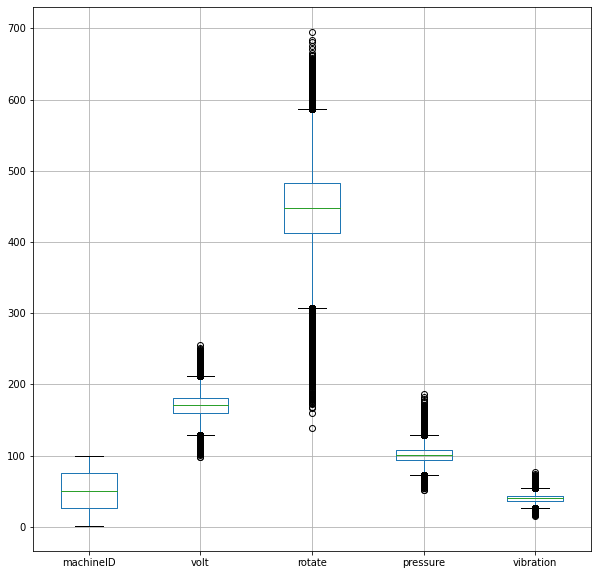

In [44]:
# 각 요인별 이상치 찾기
telemetry_df.boxplot(figsize=(10,10))
plt.show()

In [13]:
import numpy as np

In [14]:
# 각 요인별 이상치 데이터 추출하는 함수 정의
def outlier(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (IQR * 1.5)
    maximum = Q3 + (IQR * 1.5)

    machineID = []
    value = []
    for i in range(len(df[column])):
        if df[column][i]>=maximum or df[column][i]<=minimum:
            machineID.append(df['machineID'][i])
            value.append(df[column][i])
    return pd.DataFrame({'machineID': machineID, column: value})

In [15]:
# 함수 시험작동
volt_outlier = outlier(telemetry_df, 'volt')
volt_outlier.head(10)

,machineID,volt
0,1,215.656488
1,1,129.016707
2,1,127.163620
3,1,213.787102
4,1,121.502718
5,1,119.059047
6,1,216.955936
7,1,237.938518
8,1,215.114898
9,1,223.590823


In [16]:
# 각 요인별 이상치 데이터 추출
volt_outlier = outlier(telemetry_df, 'volt')
rotate_outlier = outlier(telemetry_df, 'rotate')
pressure_outlier = outlier(telemetry_df, 'pressure')
vibration_outlier = outlier(telemetry_df, 'vibration')

In [19]:
# 이상치 데이터에서 기계별로 groupby, 각 이상치가 몇번씩 측정되었는지 count
volt_out_df = pd.DataFrame(volt_outlier.groupby('machineID')['volt'].count())
rotate_out_df = pd.DataFrame(rotate_outlier.groupby('machineID')['rotate'].count())
pressure_out_df = pd.DataFrame(pressure_outlier.groupby('machineID')['pressure'].count())
vibration_out_df = pd.DataFrame(vibration_outlier.groupby('machineID')['vibration'].count())

volt_out_df.rename(columns={'volt':'volt_outliers'},inplace=True)
rotate_out_df.rename(columns={'rotate':'rotate_outliers'},inplace=True)
pressure_out_df.rename(columns={'pressure':'pressure_outliers'},inplace=True)
vibration_out_df.rename(columns={'vibration':'vibration_outliers'},inplace=True)

In [20]:
# 기계별 고장횟수 & 이상치데이터 합치기
machines_outliers = pd.concat([machines_failures, volt_out_df, rotate_out_df, pressure_out_df, vibration_out_df], axis=1)

In [21]:
machines_outliers

,failure,volt_outliers,rotate_outliers,pressure_outliers,vibration_outliers
machineID,,,,,
1,7.0,74,85,137,143
2,4.0,94,83,131,90
3,5.0,62,111,153,94
4,6.0,83,107,114,108
5,7.0,66,89,184,90
...,...,...,...,...,...
96,5.0,74,77,212,102
97,8.0,64,103,180,120
98,16.0,97,98,235,125


In [22]:
# 기계별 고장 횟수와 이상치별 측정 횟수 상관관계 찾기 (피어슨 사용)
machines_outliers.corr(method = "pearson")

,failure,volt_outliers,rotate_outliers,pressure_outliers,vibration_outliers
failure,1.000000,0.102951,0.199934,0.620790,0.532165
volt_outliers,0.102951,1.000000,0.006575,0.029780,-0.070066
rotate_outliers,0.199934,0.006575,1.000000,-0.038409,0.031573
pressure_outliers,0.620790,0.029780,-0.038409,1.000000,0.106246
vibration_outliers,0.532165,-0.070066,0.031573,0.106246,1.000000


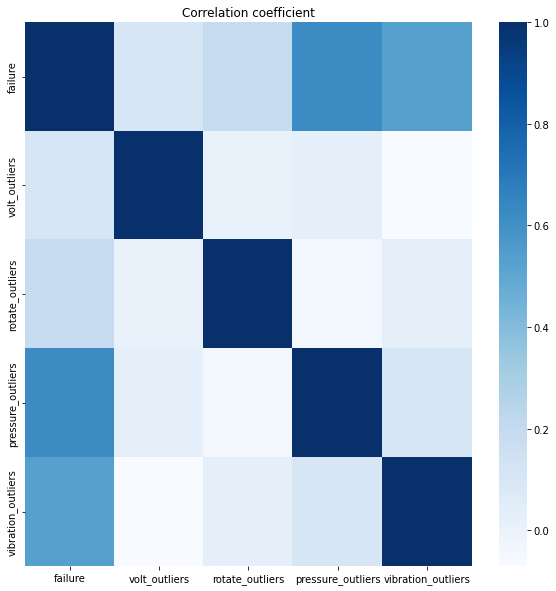

In [46]:
# 히트맵 시각화
matplotlib.rcParams['font.family'] = "NaNumGothic"  #나눔고딕체 사용
colormap = plt.cm.Blues  #색설정 : Blues
plt.figure(figsize = (10,10))
plt.title("Correlation coefficient")
sns.heatmap(machines_outliers.astype(float).corr(), cmap=colormap)
#이미지 저장
plt.savefig('heatmap2.png', transparent=True)

In [ ]:
### 고장은 압력과 진동 이상치와 상관성이 있음(상관계수 0.6, 0.5)
### 이후 개선방향 제시: 압력과 진동 이상치 발생 원인을 찾아 줄여주면 좋음.

##4. 모델 종류별 고장률 찾기
* 모델 4종류 (machines.csv)
* 고장횟수 (failures.csv)


In [27]:
# 기계별 고장 데이터 & 기계별 모델 데이터 추출하기
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())
machines_model = pd.DataFrame(machines_df[['machineID','model']]).set_index('machineID')

In [28]:
print(machines_failures.head(2))
print(machines_model.head(2))

           failure
machineID         
1                7
2                4
            model
machineID        
1          model3
2          model4


In [29]:
# 기계별 모델, 고장 데이터 합치기
model_fail = pd.concat([machines_model, machines_failures], axis=1)

In [30]:
model_fail.head(2)

,model,failure
machineID,,
1,model3,7.0
2,model4,4.0


In [31]:
# 모델별 고장 횟수 추출
models_failures = pd.DataFrame(model_fail.groupby('model')['failure'].sum())

# 모델별 보유 개수
models_count = pd.DataFrame(machines_df.groupby('model')['machineID'].count())
models_count.rename(columns={'machineID':'num'},inplace=True)

In [32]:
# 모델별 보유 개수 & 고장 횟수 합치기
models_failures_count = pd.concat([models_count, models_failures], axis=1)

In [33]:
# 고장률 컬럼 추가 (고장횟수/보유개수*100)
models_failures_count['Failure rate'] = models_failures_count['failure'] / models_failures_count['num'] *100

In [34]:
models_failures_count

,num,failure,Failure rate
model,,,
model1,16,189.0,1181.250000
model2,17,168.0,988.235294
model3,35,221.0,631.428571
model4,32,183.0,571.875000


In [ ]:
### 결론 : 모델1,2가 고장률이 높은 걸 알 수 있음. 앞으로 기계 전체를 교체 시에는 모델 3 또는 4로 교체하는게 좋을 듯.

## 3.부품별 교체주기
* 고장나서 교체한 주기
* 정기적 교체 주기
* 전체 교체 주기

In [ ]:
# 1. 고장나서 교체한 데이터만 추출
# failures.csv에는 2015년도 데이터만 있으므로, maint.csv에서 2015년 데이터만 추출해서 비교.
maint_df_2015 = maint_df[maint_df['datetime'].str.contains('2015')]

In [ ]:
maint_df_2015

,datetime,machineID,comp
4,2015-01-05 06:00:00,1,comp4
5,2015-01-05 06:00:00,1,comp1
6,2015-01-20 06:00:00,1,comp3
7,2015-01-20 06:00:00,1,comp1
8,2015-02-04 06:00:00,1,comp4
...,...,...,...
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2


In [ ]:
## maint_df_2015에서 failures_df와 같은 datetime 데이터만 추출

In [ ]:
# 공통된 날짜에 해당하는 데이터 추출하기
fail_maint = pd.merge(failures_df, maint_df_2015, on='datetime')

In [ ]:
# 고장난 기계, 부품 같은 데이터만 추출
fail_maint = fail_maint[fail_maint['failure']==fail_maint['comp']]
fail_maint = fail_maint[fail_maint['machineID_x']==fail_maint['machineID_y']]

In [ ]:
fail_maint.head(10)

,datetime,machineID_x,failure,machineID_y,comp
0,2015-01-05 06:00:00,1,comp4,1,comp4
12,2015-01-05 06:00:00,23,comp2,23,comp2
24,2015-01-05 06:00:00,64,comp4,64,comp4
37,2015-01-05 06:00:00,69,comp2,69,comp2
48,2015-01-05 06:00:00,84,comp2,84,comp2
50,2015-03-06 06:00:00,1,comp1,1,comp1
58,2015-04-20 06:00:00,1,comp2,1,comp2
73,2015-04-20 06:00:00,11,comp2,11,comp2
88,2015-04-20 06:00:00,11,comp3,11,comp3
107,2015-04-20 06:00:00,69,comp4,69,comp4


In [ ]:
fail_maint.nunique()

datetime       301
machineID_x     98
failure          4
machineID_y     98
comp             4
dtype: int64

In [ ]:
fail_maint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 0 to 7501
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   datetime     743 non-null    object
 1   machineID_x  743 non-null    int64 
 2   failure      743 non-null    object
 3   machineID_y  743 non-null    int64 
 4   comp         743 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB


In [ ]:
# 부품별 데이터로 분리
fail_maint1 = fail_maint[fail_maint['comp']=='comp1'].sort_values(by=['datetime'], ascending=True).reset_index()
fail_maint2 = fail_maint[fail_maint['comp']=='comp2'].sort_values(by=['datetime'], ascending=True).reset_index()
fail_maint3 = fail_maint[fail_maint['comp']=='comp3'].sort_values(by=['datetime'], ascending=True).reset_index()
fail_maint4 = fail_maint[fail_maint['comp']=='comp4'].sort_values(by=['datetime'], ascending=True).reset_index()

In [ ]:
fail_maint1

,index,datetime,machineID_x,failure,machineID_y,comp
0,4721,2015-01-02 06:00:00,24,comp1,24,comp1
1,4746,2015-01-02 06:00:00,81,comp1,81,comp1
2,416,2015-01-07 06:00:00,12,comp1,12,comp1
3,429,2015-01-07 06:00:00,75,comp1,75,comp1
4,5061,2015-01-10 06:00:00,32,comp1,32,comp1
...,...,...,...,...,...,...
178,3255,2015-12-27 06:00:00,17,comp1,17,comp1
179,4214,2015-12-30 06:00:00,88,comp1,88,comp1
180,2379,2015-12-31 06:00:00,64,comp1,64,comp1
181,2416,2015-12-31 06:00:00,95,comp1,95,comp1


In [ ]:
fail_maint1_mac1 = fail_maint1[fail_maint1['machineID_x']==5]

In [ ]:
fail_maint1_mac1

,index,datetime,machineID_x,failure,machineID_y,comp
34,828,2015-02-23 06:00:00,5,comp1,5,comp1
62,834,2015-04-09 06:00:00,5,comp1,5,comp1
136,857,2015-09-06 06:00:00,5,comp1,5,comp1
163,879,2015-11-20 06:00:00,5,comp1,5,comp1


In [ ]:
# datetime 을 이용한 교체주기 확인
def rep_cycle(df):
    comp_re = []
    n = 1
    for i in range(len(df)-1):
        if n != len(df):
            str_datetime1 = df['datetime'][n]
            str_datetime2 = df['datetime'][i]
            currdate1 = datetime.strptime(str_datetime1, '%Y-%m-%d %H:%M:%S')
            currdate2 = datetime.strptime(str_datetime2, '%Y-%m-%d %H:%M:%S')
            new = currdate1- currdate2
            comp_re.append(new.days)
            n += 1
        else:
            break
    mean_fail_maint = sum(comp_re)/len(comp_re)
    return mean_fail_maint

In [ ]:
rep_cycle1 = rep_cycle(fail_maint1)
rep_cycle2 = rep_cycle(fail_maint2)
rep_cycle3 = rep_cycle(fail_maint3)
rep_cycle4 = rep_cycle(fail_maint4)
print(rep_cycle1)
print(rep_cycle2)
print(rep_cycle3)
print(rep_cycle4)

1.9945054945054945
1.407843137254902
2.84251968503937
2.0628571428571427
